# Лабораторна робота 3
## Базові алгоритми навчання без вчителя та обробка текстових даних
### Щербакова Валерія, ФІ-71
Dataset: https://www.kaggle.com/jacobbaruch/basketball-players-stats-per-season-49-leagues

In [500]:
import numpy as np, pandas as pd, seaborn as sb, dabl, imageio, colorsys, math, nltk
import os, pandas as pd, matplotlib as mpl, sklearn as skl, scipy.stats as ss
from sklearn import linear_model as slm, model_selection as slms
from sklearn import metrics as sklm, ensemble as skle, preprocessing as sklp
from sklearn import neighbors as skln, tree as sklt, svm as skls
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from nltk.corpus import brown, stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation

### 1. Зниження розмірності і візуалізація даних

In [3]:
data = pd.read_csv(r'players_stats_by_season_full_details.csv')

In [4]:
print('Columns:', data.columns)
print('\nDataset size:', len(data))

Columns: Index(['League', 'Season', 'Stage', 'Player', 'Team', 'GP', 'MIN', 'FGM',
       'FGA', '3PM', '3PA', 'FTM', 'FTA', 'TOV', 'PF', 'ORB', 'DRB', 'REB',
       'AST', 'STL', 'BLK', 'PTS', 'birth_year', 'birth_month', 'birth_date',
       'height', 'height_cm', 'weight', 'weight_kg', 'nationality',
       'high_school'],
      dtype='object')

Dataset size: 53798


Застосуйте методи зниження розмірності sklearn.decomposition.PCA і
sklearn.manifold.TSNE для візуалізації даних, з якими ви працювали в лабораторній № 2 (знижуючи розмірність до двох). Візуалізуйте результат.

In [5]:
cdata = data.dropna(subset=['birth_year', 'height_cm', 'weight_kg'])

adata = cdata[['GP','MIN','FGM','FGA','3PM','3PA','FTM','FTA','TOV','PF','ORB','DRB','REB','AST','STL','BLK','PTS',
               'birth_year', 'height_cm', 'weight_kg']]
bdata = data[['GP','MIN','FGM','FGA','3PM','3PA','FTM','FTA','TOV','PF','ORB','DRB','REB','AST','STL','BLK','PTS']]
pd.set_option('mode.chained_assignment', None)
adata[['birth_year']] -= 2021
adata[['birth_year']] *= -1
adata = adata.rename(columns={'birth_year': 'age', 'height_cm': 'height', 'weight_kg': 'weight'})

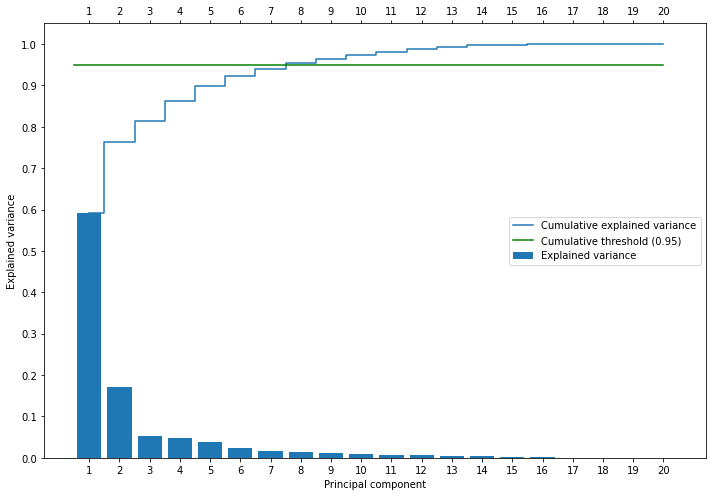

In [230]:
scaler = StandardScaler()
X_std = scaler.fit_transform(adata)

pca = PCA()
X_pca = pca.fit_transform(X_std)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

fig = plt.figure(figsize=(10,7))
ax = plt.gca()
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, align='center', label='Explained variance')
plt.step(range(1,len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.plot([0.5,len(cum_sum_eigenvalues)], [0.95, 0.95], color='green', label='Cumulative threshold (0.95)')
plt.ylabel('Explained variance')
plt.xlabel('Principal component')
plt.xticks(np.arange(1, len(cum_sum_eigenvalues)+1, 1.0))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.legend(loc='right')
plt.tight_layout()
plt.show()

In [ ]:
pca2 = PCA(n_components=2)
pca2_result = pca2.fit_transform(adata)

pca2_norm = PCA(n_components=2)
pca2_norm_result = pca2_norm.fit_transform(X_std)

def classify(row):
    crit = row['PTS']
    if crit < 200: return 0
    if crit < 400: return 1
    if crit < 800: return 2
    if crit < 1600: return 3
    return 4

labels = adata.apply(lambda row: classify(row), axis=1)

pca2_result_df = pd.DataFrame({'pca_1': pca2_result[:,0], 
                               'pca_2': pca2_result[:,1], 
                               'label': labels})

pca2_norm_result_df = pd.DataFrame({'pca_1_norm': pca2_norm_result[:,0], 
                                    'pca_2_norm': pca2_norm_result[:,1], 
                                    'label': labels})

In [ ]:
tsne2 = TSNE(n_components=2, random_state=2021_11_20, learning_rate='auto', init='random', n_iter=500)
tsne2_result = tsne2.fit_transform(adata)

tsne2_norm = TSNE(n_components=2, random_state=2021_11_20, learning_rate='auto', init='random', n_iter=500)
tsne2_norm_result = tsne2.fit_transform(X_std)

def classify(row):
    crit = row['PTS']
    if crit < 200: return 0
    if crit < 400: return 1
    if crit < 800: return 2
    if crit < 1600: return 3
    return 4

labels = adata.apply(lambda row: classify(row), axis=1)

tsne2_result_df = pd.DataFrame({'tsne_1': tsne2_result[:,0], 
                                'tsne_2': tsne2_result[:,1], 
                                'label': labels})

tsne2_norm_result_df = pd.DataFrame({'tsne_1_norm': tsne2_norm_result[:,0], 
                                     'tsne_2_norm': tsne2_norm_result[:,1], 
                                     'label': labels})

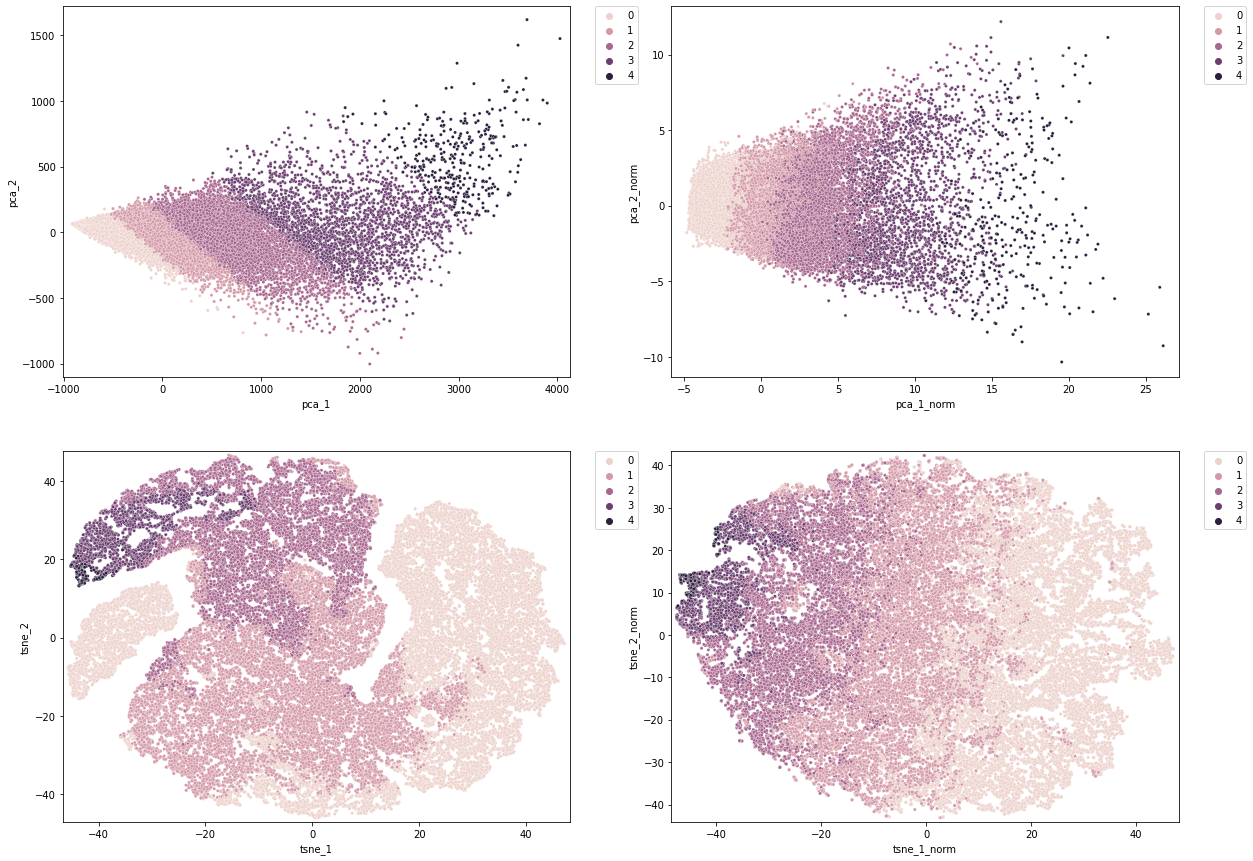

In [222]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(20,15)

ax = axs[0,0]
sb.scatterplot(x='pca_1', y='pca_2', hue='label', data=pca2_result_df, ax=ax, s=10)
ax.set_xlim((pca2_result[:,0].min()-100, pca2_result[:,0].max()+100))
ax.set_ylim((pca2_result[:,1].min()-100, pca2_result[:,1].max()+100))
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

ax = axs[0,1]
sb.scatterplot(x='pca_1_norm', y='pca_2_norm', hue='label', data=pca2_norm_result_df, ax=ax, s=10)
ax.set_xlim((pca2_norm_result[:,0].min()-1, pca2_norm_result[:,0].max()+1))
ax.set_ylim((pca2_norm_result[:,1].min()-1, pca2_norm_result[:,1].max()+1))
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

ax = axs[1,0]
sb.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne2_result_df, ax=ax, s=10)
ax.set_xlim((tsne2_result[:,0].min()-1, tsne2_result[:,0].max()+1))
ax.set_ylim((tsne2_result[:,1].min()-1, tsne2_result[:,1].max()+1))
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

ax = axs[1,1]
sb.scatterplot(x='tsne_1_norm', y='tsne_2_norm', hue='label', data=tsne2_norm_result_df, ax=ax, s=10)
ax.set_xlim((tsne2_norm_result[:,0].min()-1, tsne2_norm_result[:,0].max()+1))
ax.set_ylim((tsne2_norm_result[:,1].min()-1, tsne2_norm_result[:,1].max()+1))
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

### 2. Кластерний аналіз

1\) За допомогою алгоритму k-means зробіть квантування зображення (видалення візуально надлишкової інформації) з глибиною 64, 32, 16 та 8 рівнів для будь-якого обраного самостійно зображення.

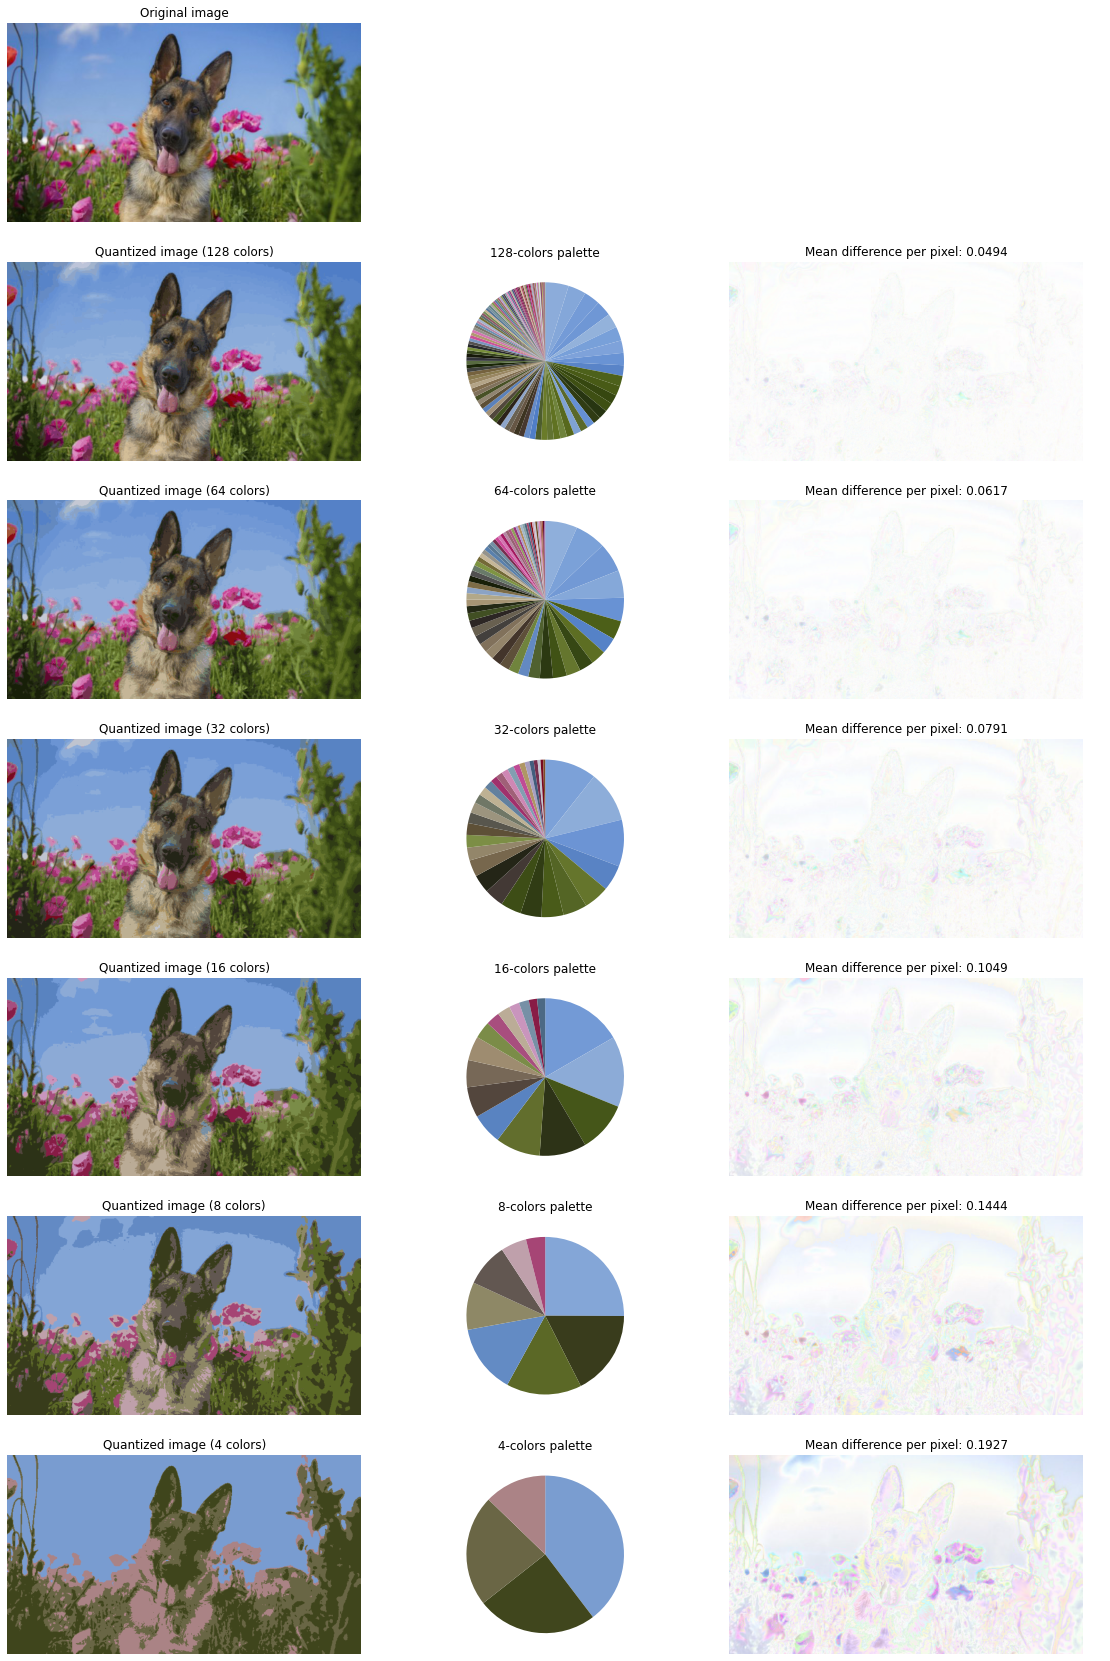

In [231]:
img = np.array(imageio.imread('lab3img.jpg'), dtype=np.float64) / 255

w, h, d = original_shape = tuple(img.shape)
img_arr = np.reshape(img, (w * h, d))

colors = [128, 64, 32, 16, 8, 4]
fig, axs = plt.subplots(1 + len(colors), 3, gridspec_kw={'width_ratios': [2, 1, 2]})
fig.set_size_inches(20,30)

axs[0,0].axis("off")
axs[0,0].set_title("Original image")
axs[0,0].imshow(img)

axs[0,1].pie([1], colors=[[1,1,1]])
axs[0,1].axis("off")
axs[0,2].axis("off")

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)

img_arr_sample = shuffle(img_arr, random_state=2021_11_20, n_samples=1_000)

i = 1
for n_colors in colors:
    kmeans = KMeans(n_clusters=n_colors, random_state=2021_11_20).fit(img_arr_sample)
    labels = kmeans.predict(img_arr)
    quantized = recreate_image(kmeans.cluster_centers_, labels, w, h)
    unique, counts = np.unique(labels, return_counts=True)
    label_occurences = dict(zip(unique, counts))
    sorted_iter = sorted(label_occurences.items(), key=lambda item: item[1], reverse=True)
    palette = [kmeans.cluster_centers_[k] for k, v in sorted_iter]
    palette_count = [v for k, v in sorted_iter]
    # Quantized image
    axs[i,0].axis("off")
    axs[i,0].set_title(f"Quantized image ({n_colors} colors)")
    axs[i,0].imshow(quantized)
    # Palette
    axs[i,1].axis("off")
    axs[i,1].set_title(f"{n_colors}-colors palette")
    axs[i,1].pie(palette_count, colors=palette, counterclock=False, startangle=90)
    # Difference
    axs[i,2].axis("off")
    diff_img = np.abs(quantized - img)
    axs[i,2].set_title("Mean difference per pixel: " + str(round(np.mean(np.sum(diff_img, axis=2)), 4)))
    axs[i,2].imshow(1 - diff_img)
    # End!
    i += 1

In [232]:
differences = []
for n_colors in range(2,256):
    kmeans = KMeans(n_clusters=n_colors, random_state=2021_11_20).fit(img_arr_sample)
    labels = kmeans.predict(img_arr)
    quantized = recreate_image(kmeans.cluster_centers_, labels, w, h)
    diff_img = np.abs(quantized - img)
    differences.append(np.mean(np.sum(diff_img, axis=2)))

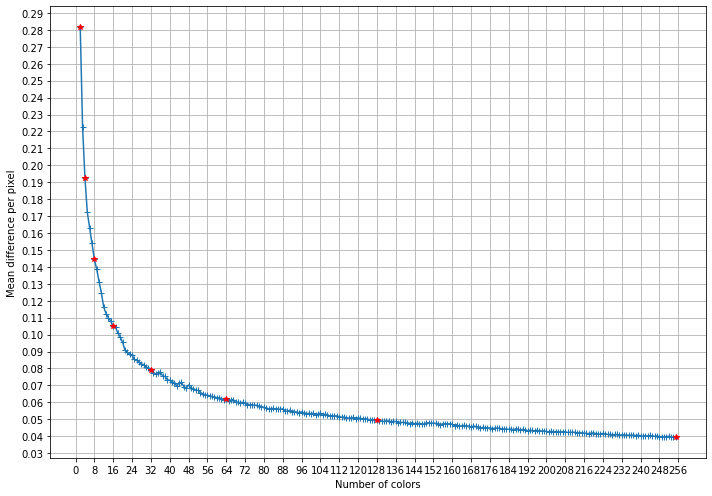

In [299]:
plt.figure(figsize=(10,7))
plt.plot(range(2,256), differences, '-+')
important = [2,4,8,16,32,64,128,255]
plt.plot(important, [differences[i-2] for i in important], 'r*') 
plt.ylabel('Mean difference per pixel')
plt.xlabel('Number of colors')
plt.xticks(np.arange(0, 257, 8))
plt.yticks(np.arange(0.03, 0.3, 0.01))
plt.grid()
plt.tight_layout()
plt.show()

2\) Згенеруйте набір синтетичних даних у вигляді суміші двох гаусіан за допомогою функції: numpy.random.multivariate_normal

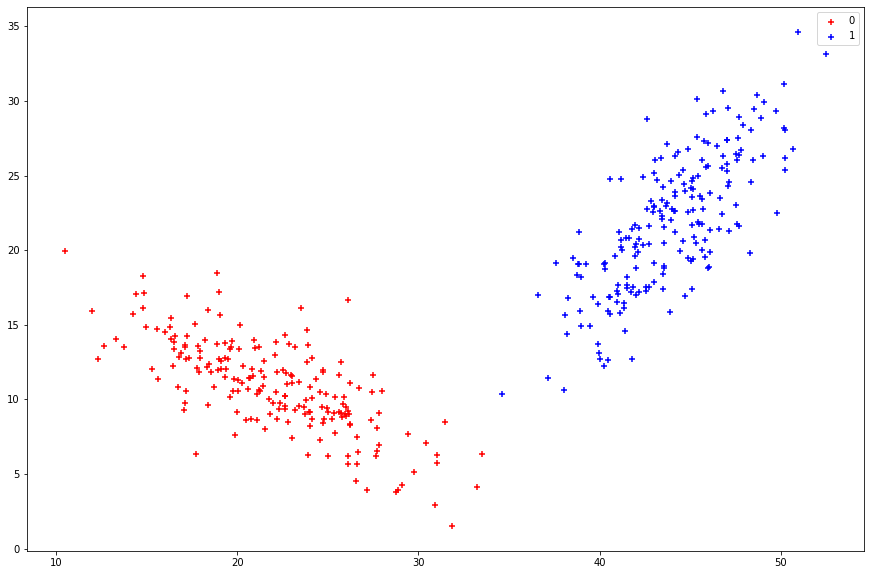

In [227]:
points = 200      
mean_1 = [22, 11] 
cov_1 = [[20, -10],
         [-10, 10]]
mean_2 = [44, 22] 
cov_2 = [[10, 10],
         [10, 20]]
# -------------------------------------------------
pts_1 = np.random.multivariate_normal(mean_1, cov_1, points)
pts_2 = np.random.multivariate_normal(mean_2, cov_2, points)
# -------------------------------------------------
plt.figure(figsize=(15, 10))
plt.scatter(pts_1[:, 0], pts_1[:, 1], marker = '+', color='red', label='0')
plt.scatter(pts_2[:, 0], pts_2[:, 1], marker = '+', color='blue', label='1')
plt.legend()
# -------------------------------------------------
pts = np.concatenate((pts_1, pts_2))

Розділіть суміш за допомогою EM алгоритму (sklearn.mixture.GaussianMixture), зверніть увагу на параметр covariance_type. За допомогою атрибутів weights_ і covariances_ відновіть їхні значення, порівняйте з оригінальними. Візуалізуйте результат.

In [206]:
gm = GaussianMixture(2, random_state=2021_11_20)
gm.fit(pts)
print('Real means:')
print(np.array([mean_1, mean_2]))
print()
print('Predicted means:')
print(gm.means_)
print()
print('Real covariances:')
print(np.array([cov_1, cov_2]))
print()
print('Predicted covariances:')
print(gm.covariances_)

Real means:
[[22 11]
 [44 22]]

Predicted means:
[[22.51249638 10.43378655]
 [43.80800796 21.60850134]]

Real covariances:
[[[ 20 -10]
  [-10  10]]

 [[ 10  10]
  [ 10  20]]]

Predicted covariances:
[[[19.03550759 -9.86102153]
  [-9.86102153  9.90046341]]

 [[10.22401166 10.33126322]
  [10.33126322 18.95622805]]]


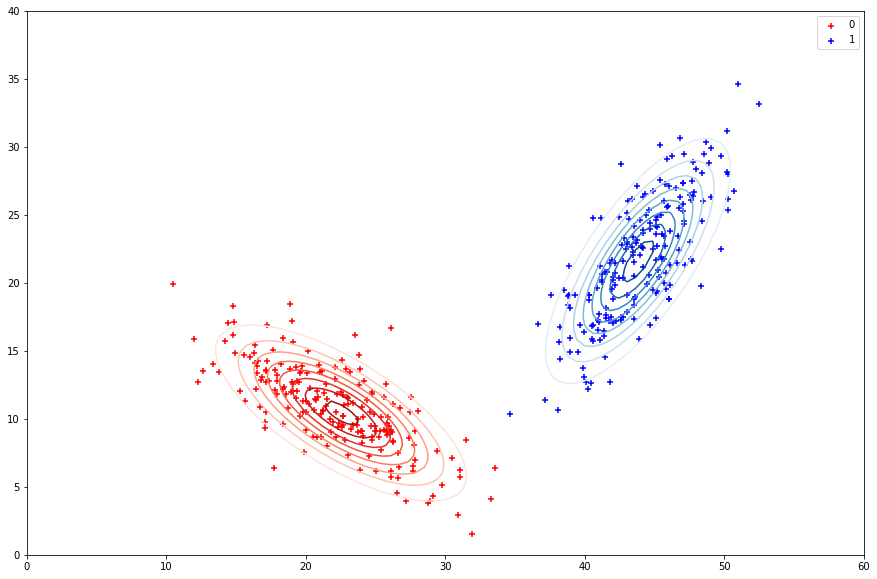

In [228]:
d1 = ss.multivariate_normal(gm.means_[0], gm.covariances_[0])
d2 = ss.multivariate_normal(gm.means_[1], gm.covariances_[1])

X, Y = np.meshgrid(np.linspace(0, 60, 100), np.linspace(0, 40, 100))
Z1 = np.array([d1.pdf(xy) for xy in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)
Z2 = np.array([d2.pdf(xy) for xy in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

plt.figure(figsize=(15, 10))
plt.contour(X, Y, Z2, 10, cmap='Blues')
plt.contour(X, Y, Z1, 10, cmap='Reds')
plt.scatter(pts_1[:, 0], pts_1[:, 1], marker = '+', color='red', label='0')
plt.scatter(pts_2[:, 0], pts_2[:, 1], marker = '+', color='blue', label='1')
plt.legend()

### 3. Обробка текстових даних
Завантажте набір текстових даних (з мітками класів).

Я використовую NLTK Brown Corpus (https://www.nltk.org/book/ch02.html#tab-brown-sources)

In [319]:
nltk.download('brown')
nltk.download('stopwords')

[nltk_data] Downloading package brown to /home/vale/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vale/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [309]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

Оскільки "в разі великої кількості класів достатньо залишити 2-3", я розглядатиму категорії adventure, mystery та romance.

Проведіть передобробку даних (видаліть стоп-слова, пунктуацію)

In [464]:
stop_words = stopwords.words('english')
for punct in ["''", "``", "--", "one", "said", "back", "man", "time"]:
    stop_words.append(punct)

cat_map = {0: 'adventure', 1: 'mystery', 2: 'romance'}
rev_map = {v:k for k,v in cat_map.items()}

paragraphs = {
    cat_id: [[[w.lower() for w in sents if w.lower() not in stop_words and len(w) >= 2] 
               for sents in p] for p in brown.paras(categories=cat_value)]
    for cat_id, cat_value in cat_map.items()
}

за допомогою wordcloud зробіть візуалізацію найбільш поширених слів або n-gram у кожному класі

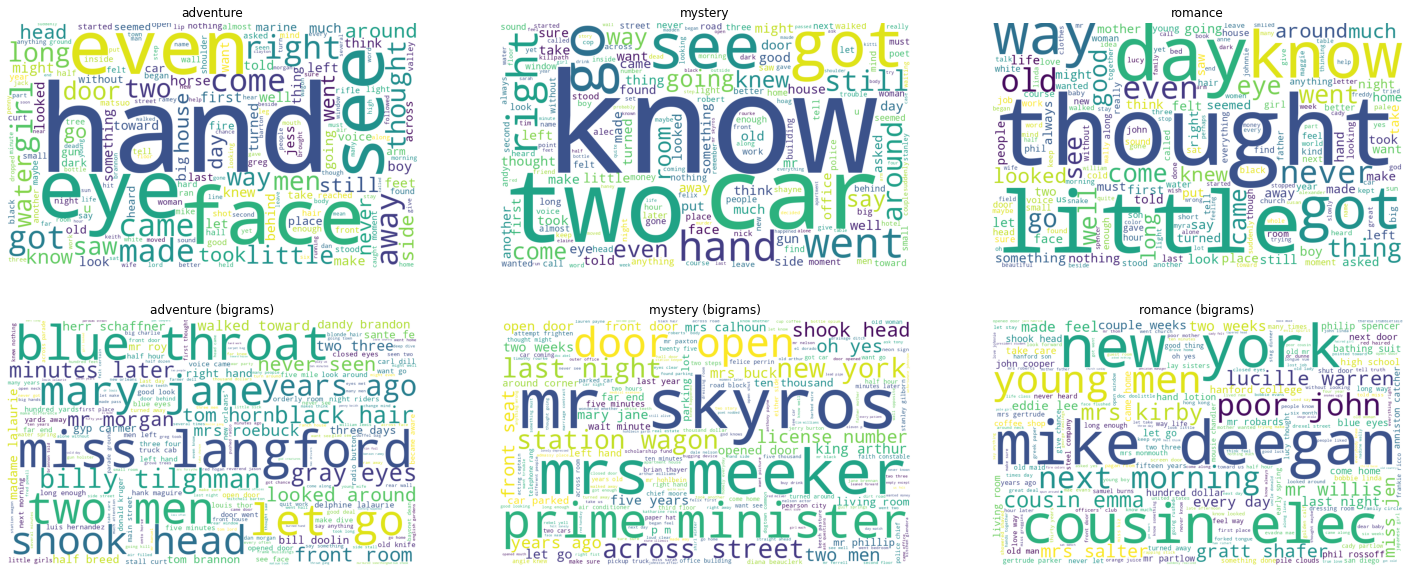

In [480]:
def visualize(cat_id, ax, ax2):
    texts = []
    for para in paragraphs[cat_id]:
        for sent in para:
            texts.append(' '.join(sent))
    text = ' '.join(texts)
    wordcloud = WordCloud(width=1000, height=600, background_color="white", random_state=2).generate(text)
    ax.set_title(cat_map[cat_id])
    ax.imshow(wordcloud)
    ax.axis('off')
    wordcloud2 = WordCloud(width=1000, height=600, background_color="white", random_state=2, collocation_threshold=0).generate(text)
    ax2.set_title(cat_map[cat_id] + ' (bigrams)')
    ax2.imshow(wordcloud2)
    ax2.axis('off')

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(25,10)

for i in range(0, len(cat_map)):
    visualize(i, axs[0, i], axs[1, i])

Векторизуйте тексти (наприклад за допомогою sklearn.feature_extraction.text.TfidfVectorizer)

In [506]:
texts = []
labels = []
cat_texts = {0:[], 1:[], 2:[]}

for cat_id in cat_map:
    for para in paragraphs[cat_id]:
        sent_str = []
        for sent in para:
            sent_str.append(' '.join(sent))
        string = ' '.join(sent_str)
        texts.append(string)
        cat_texts[cat_id].append(string)
        labels.append(cat_id)
        
train_texts, test_texts, train_labels, test_labels = \
    slms.train_test_split(texts, labels, test_size=0.3, random_state=2021_11_20)

In [498]:
count_vectorizer = CountVectorizer()
train_count_vectorizer = count_vectorizer.fit_transform(train_texts)
test_count_vectorizer = count_vectorizer.transform(test_texts)

tfidf_vectorizer = TfidfVectorizer()
train_tfidf_vectorizer = tfidf_vectorizer.fit_transform(train_texts)
test_tfidf_vectorizer = tfidf_vectorizer.transform(test_texts)

Проведіть класифікацію текстових даних, зробіть оцінку якості.

In [499]:
clf_c = LogisticRegression(random_state=2021_11_20).fit(train_count_vectorizer, train_labels)
predicted_c = clf_c.predict(test_count_vectorizer)

print('CountVectorizer')
print(classification_report(test_labels, predicted_c))
print(confusion_matrix(test_labels, predicted_c))


clf_t = LogisticRegression(random_state=2021_11_20).fit(train_tfidf_vectorizer, train_labels)
predicted_t = clf_t.predict(test_tfidf_vectorizer)

print('\n')
print('TfIdfVectorizer')
print(classification_report(test_labels, predicted_t))
print(confusion_matrix(test_labels, predicted_t))

print('\n')
print('Count -> TfIdf change in CM:')
print(confusion_matrix(test_labels, predicted_t) - confusion_matrix(test_labels, predicted_c))

CountVectorizer
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       388
           1       0.72      0.63      0.67       360
           2       0.68      0.73      0.70       394

    accuracy                           0.70      1142
   macro avg       0.71      0.70      0.70      1142
weighted avg       0.71      0.70      0.70      1142

[[289  36  63]
 [ 58 227  75]
 [ 54  51 289]]


TfIdfVectorizer
              precision    recall  f1-score   support

           0       0.67      0.83      0.74       388
           1       0.82      0.61      0.70       360
           2       0.74      0.74      0.74       394

    accuracy                           0.73      1142
   macro avg       0.74      0.72      0.73      1142
weighted avg       0.74      0.73      0.73      1142

[[321  25  42]
 [ 81 219  60]
 [ 79  24 291]]


Count -> TfIdf change in CM:
[[ 32 -11 -21]
 [ 23  -8 -15]
 [ 25 -27   2]]


Застосуйте алгоритм LDA до кожного класу, визначте декілька тематик (sklearn.decomposition.LatentDirichletAllocation)

In [522]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(18, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=30)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [502]:
n_components = 5
n_top_words = 10

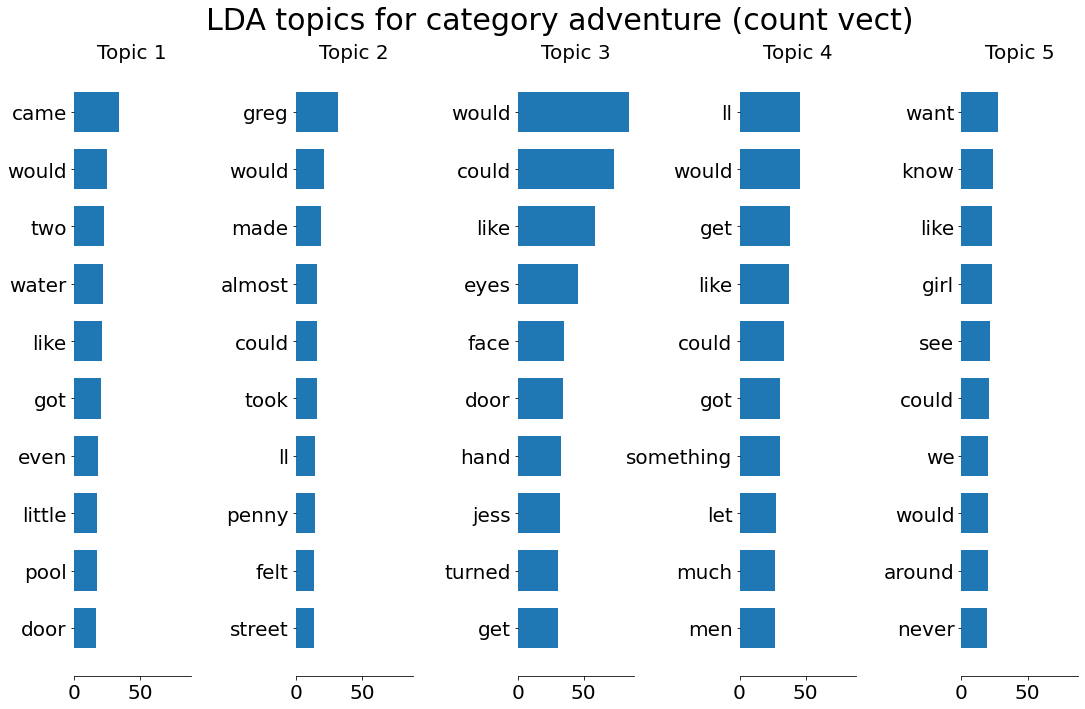

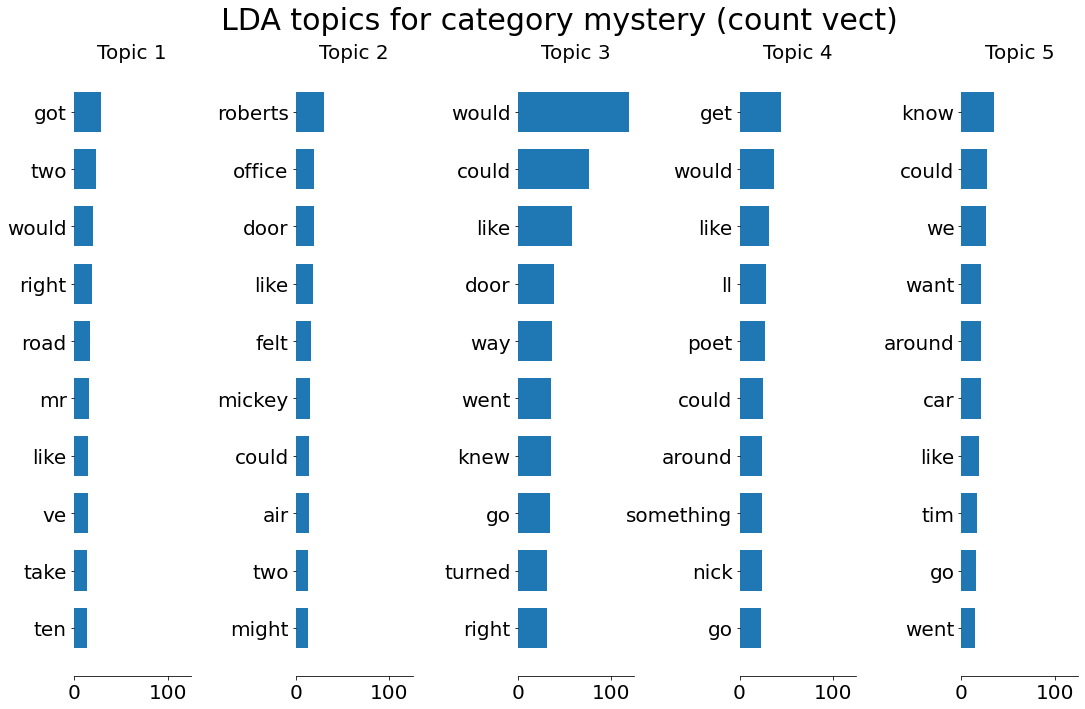

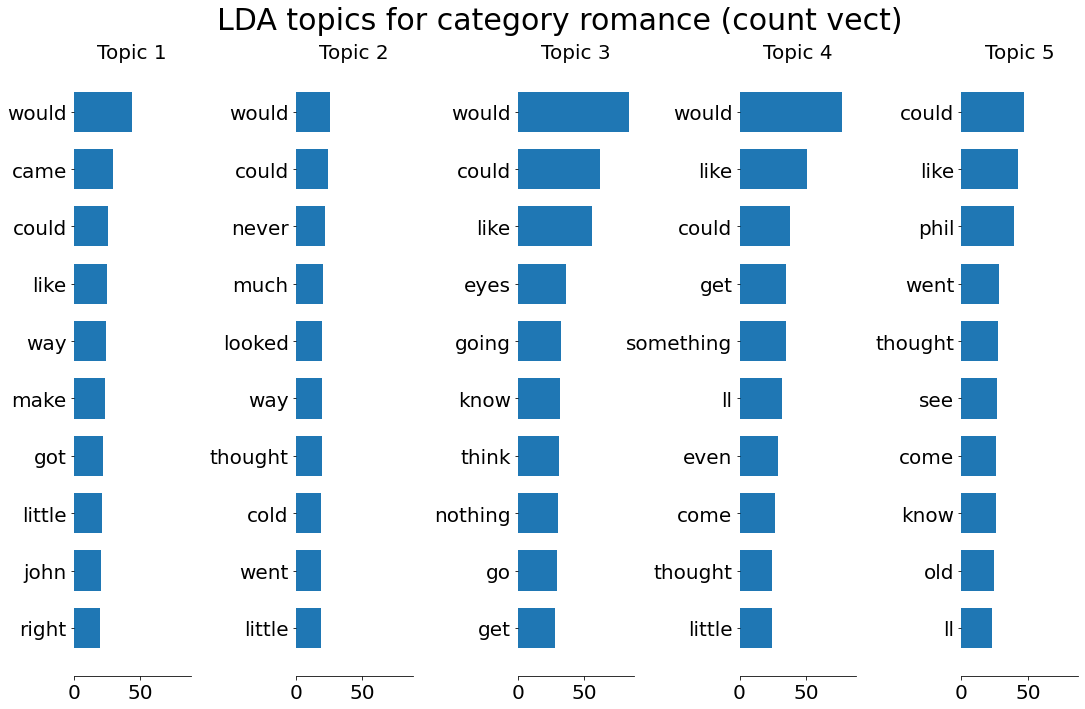

In [523]:
for cat_id in cat_map:
    lda = LatentDirichletAllocation(n_components=n_components, random_state=2021_11_20)

    data_vectorized = count_vectorizer.transform(cat_texts[cat_id])
    lda.fit(data_vectorized)

    feature_names = count_vectorizer.get_feature_names()
    plot_top_words(lda, feature_names, n_top_words, 'LDA topics for category ' + cat_map[cat_id] + ' (count vect)')

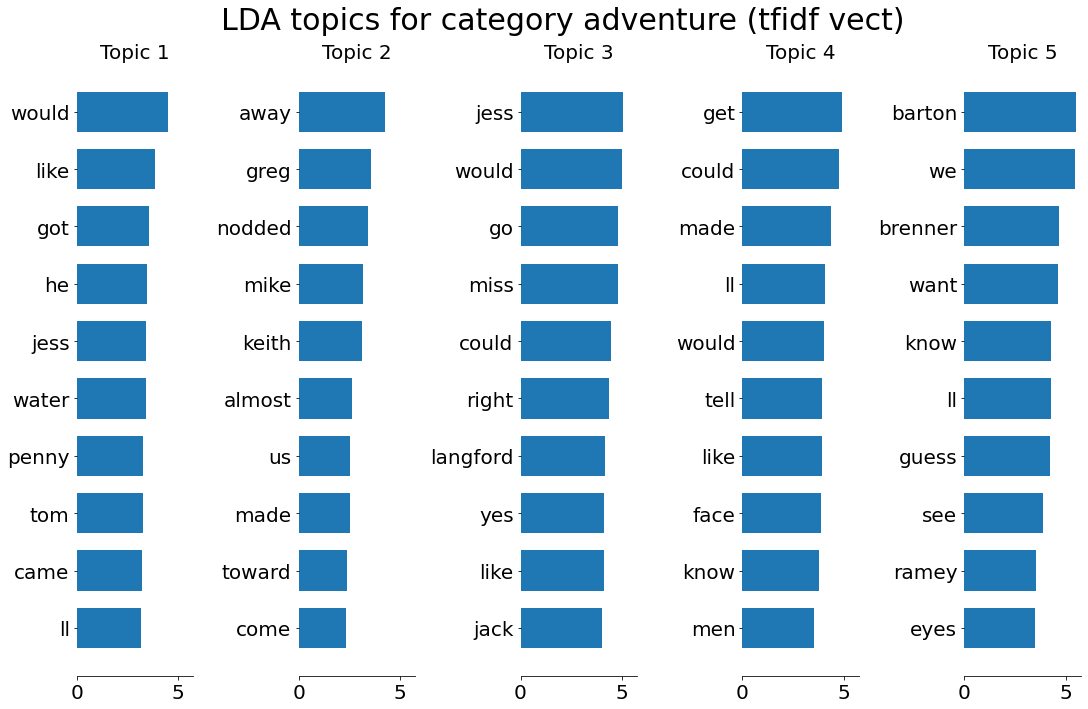

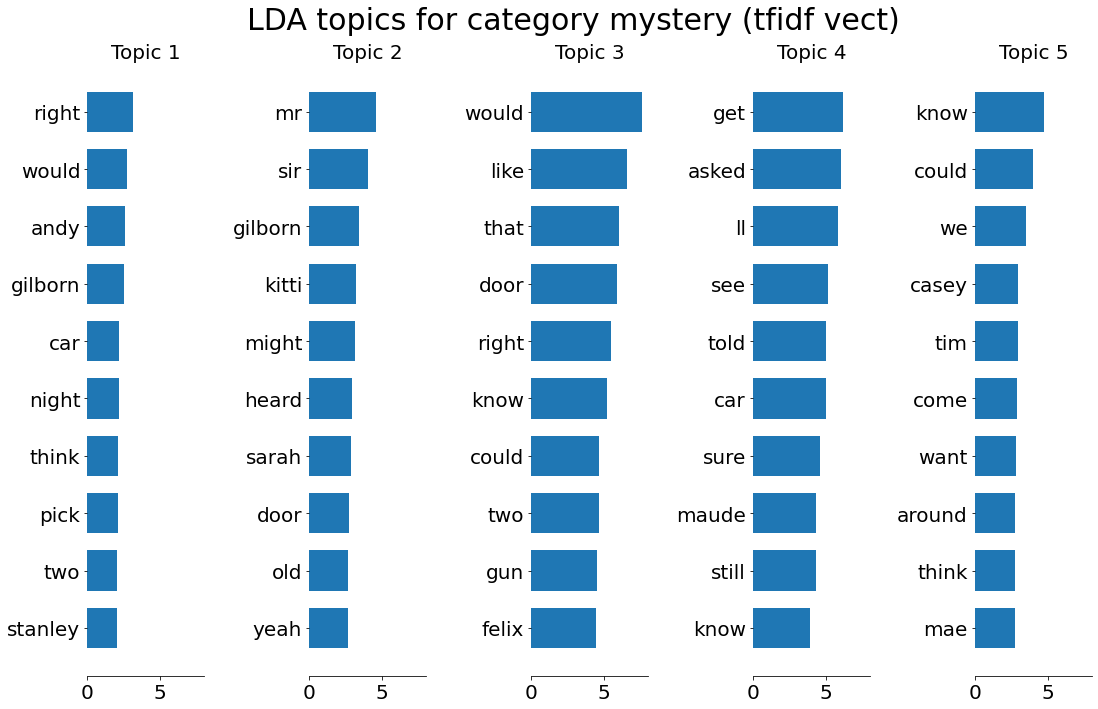

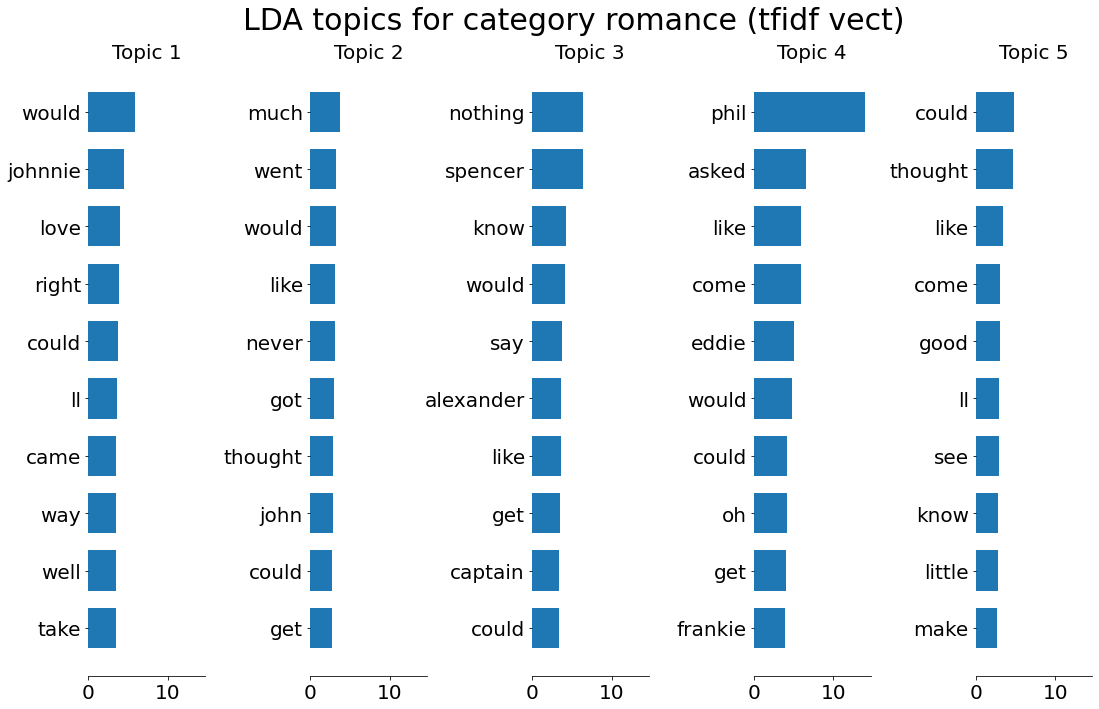

In [524]:
for cat_id in cat_map:
    lda = LatentDirichletAllocation(n_components=n_components, random_state=2021_11_20)

    data_vectorized = tfidf_vectorizer.transform(cat_texts[cat_id])
    lda.fit(data_vectorized)

    feature_names = tfidf_vectorizer.get_feature_names()
    plot_top_words(lda, feature_names, n_top_words, 'LDA topics for category ' + cat_map[cat_id] + ' (tfidf vect)')